<a href="https://colab.research.google.com/github/digitalhumanitiestextbook/dhtextbook/blob/main/chapter11/11_text_classification.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# 패키지 설치
!pip -q install transformers==4.44.2 torch --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install lime==0.2.0.1 scikit-learn==1.5.2 matplotlib==3.9.0 pandas==2.2.2
!pip install lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 127.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 135.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 122.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [ ]:
# 데이터셋 초기화
import os
import shutil
import requests
import zipfile


# input 폴더 및 하위 폴더 경로 설정
input_dir = "input"
zip_path = "input.zip"
shakespeare_plays_xml_dir = os.path.join(input_dir, "shakespeare_plays_xml")
shakespeare_plays_txt_dir = os.path.join(input_dir, "shakespeare_plays_txt")
data_a = os.path.join(input_dir, "data_a")
data_b = os.path.join(input_dir, "data_b")
data_c = os.path.join(input_dir, "data_c")

# output 폴더 경로 설정
output_dir = "output"

# train 폴더 경로 설정
train_dir = "train"
log_dir = "logs"

# output, train 폴더 검증
for folder in [output_dir, train_dir, log_dir]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# # 파일 경로와 다운로드 링크
url = "https://raw.githubusercontent.com/digitalhumanitiestextbook/dhtextbook/c26213272c77aaac58e2a0e407380106d7db5205/chapter11/input.zip"
# 기존 input 폴더 삭제
if os.path.exists("input"):
    print("[INFO] 기존 input 폴더 삭제 중...")
    shutil.rmtree("input")

# zip 파일 다운로드
print("input.zip 다운로드 중...")
resp = requests.get(url)
resp.raise_for_status()
with open(zip_path, "wb") as f:
    f.write(resp.content)
print("다운로드 완료:", zip_path)

# 압축 해제
print("압축 해제 중...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(".")
print("압축 해제 완료")

In [ ]:
# 기본설정 1. XML 파일을 TXT로 변환 후 저장
import xml.etree.ElementTree as ET
from pathlib import Path

# TEI(XML) 네임스페이스 정의
TEI_NS = "http://www.tei-c.org/ns/1.0"
NS = {"tei": TEI_NS}


# 대사 텍스트에서 토큰을 추출하는 제너레이터 함수
def yield_tokens_skipping(node):
    tag = node.tag

    # 대사 이름 / 무대지시문은 스킵
    if tag in (f"{{{TEI_NS}}}speaker", f"{{{TEI_NS}}}stage"):
        return

    # 단어 태그
    if tag == f"{{{TEI_NS}}}w" and node.text:
        yield node.text
    # 공백 태그
    elif tag == f"{{{TEI_NS}}}c":
        yield " "
    # 구두점 태그
    elif tag == f"{{{TEI_NS}}}pc" and node.text:
        yield node.text
    # 줄바꿈 / 행바꿈 태그
    elif tag == f"{{{TEI_NS}}}lb":
        yield " "
    # 행 번호(milestone) → 공백
    elif tag == f"{{{TEI_NS}}}milestone" and node.get("unit") == "ftln":
        yield " "

    # 하위 노드들을 계속 탐색
    for child in list(node):
        yield from yield_tokens_skipping(child)

# XML 파일에서 대사 텍스트 추출 함수
def extract_dialogue_text(tree):
    root = tree.getroot()
    lines = []

    # 모든 대사(sp) 요소 찾기
    for sp in root.findall(".//tei:text//tei:sp", NS):
        tokens = []
        # 대사 내용은 <ab> 안에 있으므로 반복 수집
        for ab in sp.findall(".//tei:ab", NS):
            tokens.extend(yield_tokens_skipping(ab))
        raw = "".join(tokens) # 토큰을 한 문자열로 연결
        line = " ".join(raw.split())  # 불필요한 여러 공백 제거
        # 공백 + 구두점 → 구두점만 남기도록 정리
        for p in [",", ".", "?", "!", ";", ":", ")", "]"]:
            line = line.replace(f" {p}", p)
        # 괄호 앞 공백 제거
        for p in ["(", "["]:
            line = line.replace(f"{p} ", p)
        if line:
            lines.append(line)
    # 모든 대사를 하나의 긴 문자열로 반환
    return " ".join(lines).strip()

# XML 파일 목록 가져오기
xml_files = sorted(shakespeare_plays_xml_dir.glob("*.xml"))
if not xml_files:
    print(f"No XML files found in {shakespeare_plays_xml_dir}")
else:
    # 각 XML을 순회하며 txt 파일로 변환
    for xml_path in xml_files:
        try:
            tree = ET.parse(xml_path)  # XML 파싱
            dialogue = extract_dialogue_text(tree)  # 대사 추출
            out_path = shakespeare_plays_txt_dir / f"{xml_path.stem}.txt"  # 출력 파일 경로
            out_path.write_text(dialogue, encoding="utf-8")  # 텍스트 저장
            print(f"[OK] Wrote: {out_path}")
        except Exception as e:
            print(f"[WARN] {xml_path.name}: {e}")

[OK] Wrote: /content/drive/MyDrive/Colab Notebooks/text_classification_dh_guide/shakespeare_plays/texts/A Midsummer Nights Dream.txt
[OK] Wrote: /content/drive/MyDrive/Colab Notebooks/text_classification_dh_guide/shakespeare_plays/texts/Alls Well That Ends Well.txt
[OK] Wrote: /content/drive/MyDrive/Colab Notebooks/text_classification_dh_guide/shakespeare_plays/texts/Antony And Cleopatra.txt
[OK] Wrote: /content/drive/MyDrive/Colab Notebooks/text_classification_dh_guide/shakespeare_plays/texts/As You Like It.txt
[OK] Wrote: /content/drive/MyDrive/Colab Notebooks/text_classification_dh_guide/shakespeare_plays/texts/Coriolanus.txt
[OK] Wrote: /content/drive/MyDrive/Colab Notebooks/text_classification_dh_guide/shakespeare_plays/texts/Cymbeline.txt
[OK] Wrote: /content/drive/MyDrive/Colab Notebooks/text_classification_dh_guide/shakespeare_plays/texts/Hamlet.txt
[OK] Wrote: /content/drive/MyDrive/Colab Notebooks/text_classification_dh_guide/shakespeare_plays/texts/Henry IV Part 1.txt
[OK] W

In [ ]:
# 기본설정 2. 필수 라이브러리 임포트 및 하이퍼파라미터 설정
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from lime.lime_text import LimeTextExplainer
from collections import Counter
import numpy as np

# 하이퍼파라미터 설정
Epoch = 3
Batch_size = 8
Warmup_steps = 500
Chunk_size = 512  # 토큰 수 (BERT Maximum)

# 클래스 이름 (표시용)
CLASS_NAMES = ["Class A", "Class B"]


In [ ]:
# 기본설정 3. 데이터 전처리 유틸리티 함수 정의

# 텍스트 파일을 폴더에서 읽어와 (내용, 레이블) 형태로 리스트를 만드는 함수
def load_texts(folder, label):
    texts = []

    # 폴더 안의 모든 파일 순회
    for filename in os.listdir(folder):
        # .txt 파일만 사용
        if filename.endswith('.txt'):
            # UTF-8 인코딩으로 파일 읽기
            with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
                texts.append((file.read(), label))   # (텍스트 내용, 레이블) 튜플로 저장
    return texts

# 긴 텍스트를 BERT의 최대 토큰 길이를 넘지 않도록 여러 청크로 나누는 함수 (CLS/SEP 토큰위해 max를 510으로 정의)
def chunk_text(text, tokenizer, max_tokens=510):
    words = text.split()  # 공백 기준으로 단어 단위 분할
    chunks = []  # 최종 청크 리스트
    current_chunk = []  # 현재 쌓고 있는 청크의 단어들
    current_len = 0  # 현재 청크의 토큰 길이 추정치
    for w in words:
        # 단어 w를 BERT 토크나이저로 토큰화 했을 때 토큰 개수
        tlen = len(tokenizer.tokenize(w))

        # 이 단어를 추가하면 max_tokens를 넘는 경우 → 현재 청크 확정 후 새 청크 시작
        if current_len + tlen > max_tokens:
            chunks.append(" ".join(current_chunk))
            current_chunk, current_len = [w], tlen
        else:
            # 아직 여유가 있으면 현재 청크에 계속 추가
            current_chunk.append(w)
            current_len += tlen
    # 마지막 청크가 남아 있으면 추가
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    return chunks


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# 기본설정 4. Dataset 클래스 + 평가 메트릭 함수 정의

# HuggingFace Trainer에서 사용할 수 있는 커스텀 Dataset 정의
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=512, include_labels=True):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.include_labels = include_labels

    def __len__(self):
        # 전체 샘플 수 반환
        return len(self.texts)

    def __getitem__(self, idx):
        # idx에 해당하는 샘플 하나를 반환
        data = self.texts[idx]
        if self.include_labels:
            text, label = data
        else:
            text = data

        # BERT 토크나이저로 문장을 인코딩
        enc = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # [CLS], [SEP] 토큰 자동 추가
            max_length=self.max_len,  # 최대 길이
            return_token_type_ids=False,  # 문장 구분 ID는 사용하지 않음
            padding='max_length',  # max_length까지 패딩
            return_attention_mask=True,  # attention mask 반환
            return_tensors='pt',  # PyTorch 텐서 형태로 반환
            truncation=True  # 길면 잘라내기
        )
        # Trainer가 기대하는 포맷으로 dict 구성
        item = {
            'input_ids': enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten()
        }
        # 학습/평가용일 때만 레이블 포함
        if self.include_labels:
            item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

# Trainer에서 사용하는 평가 메트릭 함수 (여기서는 accuracy만 사용)
def compute_metrics(pred):
    labels = pred.label_ids  # 정답 레이블
    preds = pred.predictions.argmax(-1)  # 가장 큰 로짓을 예측 라벨로 선택
    acc = accuracy_score(labels, preds)  # sklearn으로 정확도 계산
    return {'accuracy': acc}

In [ ]:
# BERT 토크나이저 불러오기 (bert-base-uncased 사용)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# data_a → Class 0, data_b → Class 1
texts_a = load_texts(data_a, 0)
texts_b = load_texts(data_b, 1)

# Class 문서들을 토큰 크기 제한에 맞게 여러 청크로 분해
chunked_texts_a = [(chunk, 0) for text, _ in texts_a for chunk in chunk_text(text, tokenizer)]
chunked_texts_b = [(chunk, 1) for text, _ in texts_b for chunk in chunk_text(text, tokenizer)]

# 클래스별 원본 청크 개수 출력
raw_counts = {'Class A': len(chunked_texts_a), 'Class B': len(chunked_texts_b)}
print("Raw chunk counts:", raw_counts)

# 데이터 누락 검증 (둘 중 하나라도 비어 있으면 학습 불가)
if len(chunked_texts_a) == 0 or len(chunked_texts_b) == 0:
    raise ValueError(
        "One of the classes has 0 chunks after processing. "
        "Please ensure both data_a/ and data_b/ contain .txt files with content."
    )

# 클래스 균형 맞추기 (언더샘플링)
rng = np.random.default_rng(42)  # 재현성 확보를 위한 랜덤 시드 설정
n_min = min(len(chunked_texts_a), len(chunked_texts_b))  # 두 클래스 중 더 적은 개수 n_min에 저장

# 청크 순서를 무작위로 섞은 뒤, 더 작은 클래스 개수(n_min)만큼 잘라서 균형 맞춤
rng.shuffle(chunked_texts_a)
rng.shuffle(chunked_texts_b)
balanced_a = chunked_texts_a[:n_min]
balanced_b = chunked_texts_b[:n_min]

# 두 클래스를 합치고 다시 섞기
balanced_texts = balanced_a + balanced_b
rng.shuffle(balanced_texts)

# 학습/테스트 셋 분리 (Stratified Split)
X = [t for t, y in balanced_texts]
y = [y for _, y in balanced_texts]

# 학습/테스트 셋 모두 클래스 비율을 동일하게 유지하도록 분리
train_texts_raw, test_texts_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# (문장, 레이블) 형태로 다시 결합
train_texts = list(zip(train_texts_raw, y_train))
test_texts  = list(zip(test_texts_raw,  y_test))

# HuggingFace Dataset 형태로 변환
train_dataset = TextDataset(train_texts, tokenizer)
test_dataset  = TextDataset(test_texts, tokenizer)

# 최종 데이터 개수 및 클래스 밸런스 출력
train_counts = Counter(y_train)
test_counts  = Counter(y_test)

print("Balanced chunk counts (total):", {'Class A': n_min, 'Class B': n_min, 'Total': 2*n_min})
print("Train size:", len(train_texts), "| per-class:", {CLASS_NAMES[0]: train_counts.get(0,0), CLASS_NAMES[1]: train_counts.get(1,0)})
print("Test size:",  len(test_texts),  "| per-class:", {CLASS_NAMES[0]: test_counts.get(0,0),  CLASS_NAMES[1]: test_counts.get(1,0)})


Raw chunk counts: {'Class A': 685, 'Class B': 571}
Balanced chunk counts (total): {'Class A': 571, 'Class B': 571, 'Total': 1142}
Train size: 913 | per-class: {'Class A': 456, 'Class B': 457}
Test size: 229 | per-class: {'Class A': 115, 'Class B': 114}


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
10,0.729600,0.734318,0.502183
20,0.703900,0.714017,0.502183
30,0.706700,0.685387,0.545852
40,0.688300,0.688598,0.532751
50,0.684600,0.652398,0.698690
60,0.651700,0.635336,0.812227
70,0.621700,0.539985,0.890830
80,0.529000,0.448937,0.895197
90,0.483800,0.439179,0.864629
100,0.334200,0.307970,0.921397


Evaluation Results: {'eval_loss': 0.08096247911453247, 'eval_accuracy': 0.9781659388646288, 'eval_runtime': 2.7835, 'eval_samples_per_second': 82.27, 'eval_steps_per_second': 10.418, 'epoch': 3.0}
Saved: /content/drive/MyDrive/Colab Notebooks/text_classification_dh_guide/output/training_validation_loss.png


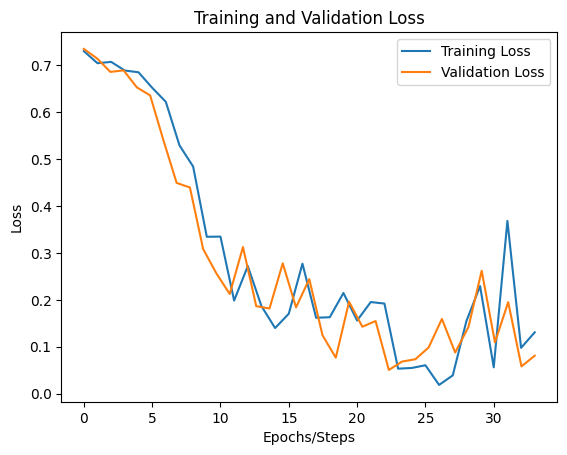

In [ ]:
# BERT 학습 설정 (TrainingArguments)
training_args = TrainingArguments(
    output_dir=train_dir,  # 모델 및 체크포인트 저장 폴더
    num_train_epochs=Epoch,  # 학습 epoch 수
    per_device_trainbatch_size=Batch_size,  # 학습용 배치 크기
    per_device_evalbatch_size=Batch_size,  # 평가용 배치 크기
    warmup_steps=Warmup_steps,  # 워밍업 스텝 수 (learning rate scheduling)
    weight_decay=0.01,  # AdamW weight decay
    logging_dir=log_dir,  # 로그 파일 저장 폴더
    logging_steps=10,  # 10 step마다 로그 기록
    evaluation_strategy='steps',  # 일정 스텝마다 평가 진행
    eval_steps=10,  # 10 step마다 평가
    report_to=[]  # wandb 등 외부 로그 시스템 비활성화
)

# BERT 분류 모델 불러오기
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Trainer 객체 생성 (학습 전체를 자동 관리)
trainer = Trainer(
    model=model,  # 학습할 모델
    args=training_args,  # 위에서 설정한 TrainingArguments
    train_dataset=train_dataset,  # 학습 데이터셋
    eval_dataset=test_dataset,  # 평가 데이터셋
    compute_metrics=compute_metrics  # 평가 시 accuracy 계산
)

# 모델 학습 실행
trainer.train()

# 테스트 셋 평가
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# 학습/검증 Loss 기록 추출 (그래프 그리기용)
train_losses = [e['loss'] for e in trainer.state.log_history if 'loss' in e]
validation_losses = [e['eval_loss'] for e in trainer.state.log_history if 'eval_loss' in e]

# Loss 곡선 시각화 및 저장
epochs = range(len(train_losses))  # 학습 스텝 기반 x축 생성
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')  # 학습 loss 그래프
if validation_losses:
    valid_steps = np.linspace(0, max(epochs) if epochs else 1, num=len(validation_losses))
    plt.plot(valid_steps, validation_losses, label='Validation Loss')
plt.xlabel('Epochs/Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# PNG 파일로 저장
save_path = os.path.join(output_dir, 'training_validation_loss.png')
plt.savefig(save_path)
print("Saved:", save_path)

In [ ]:
# Google Colab 환경에서 생성된 PNG 파일을 로컬로 다운로드
from google.colab import files

files.download(save_path)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
    accuracy_score
)

# test_dataset에 대한 예측 수행
pred_out = trainer.predict(test_dataset)

# 정답 레이블과 예측 라벨 추출
labels = pred_out.label_ids
preds  = pred_out.predictions.argmax(-1)

# 라벨 정의 및 클래스 이름 처리
all_labels = [0, 1]  # 이번 실험에서 사용하는 모든 라벨 값 (0, 1 이진 분류)

# 클래스 이름 개수와 라벨 개수가 다르면, 라벨 인덱스를 기반으로 이름 재구성
if len(CLASS_NAMES) != len(all_labels):
    CLASS_NAMES = [f'Class {i}' for i in all_labels]

# Confusion Matrix 및 주요 지표 계산
# 라벨 순서를 ALL_LABELS로 고정하여 Confusion Matrix 계산
cm = confusion_matrix(labels, preds, labels=all_labels)

# 전체 정확도
accuracy = accuracy_score(labels, preds)
# 각 클래스별 precision / recall / f1 / support
prec_cls, rec_cls, f1_cls, sup_cls = precision_recall_fscore_support(
    labels, preds, labels=all_labels, zero_division=0
)
# macro 평균 (클래스를 동일 가중치로 평균)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
# weighted 평균 (support를 가중치로 평균)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)

# 특이도(Specificity) 계산 예시
TN = cm[0, 0]
FP = cm[0, 1]
specificity_pos1 = (TN / (TN + FP)) if (TN + FP) > 0 else 0.0

# 지표를 테이블(데이터프레임)로 정리
metrics_rows = []

# 각 클래스별 지표 행 추가
for i, name in enumerate(CLASS_NAMES):
    metrics_rows.append({
        'class': name,
        'precision': prec_cls[i],
        'recall': rec_cls[i],
        'f1': f1_cls[i],
        'support': sup_cls[i]
    })
# macro / weighted 평균 행 추가
metrics_rows += [
    {'class': 'macro_avg',    'precision': prec_macro,    'recall': rec_macro,    'f1': f1_macro,    'support': np.sum(sup_cls)},
    {'class': 'weighted_avg', 'precision': prec_weighted, 'recall': rec_weighted, 'f1': f1_weighted, 'support': np.sum(sup_cls)},
    {'class': 'overall',      'precision': np.nan,        'recall': np.nan,       'f1': np.nan,      'support': np.sum(sup_cls), 'accuracy': accuracy, 'specificity_pos1': specificity_pos1},
]

metrics_df = pd.DataFrame(metrics_rows)

In [ ]:
# Confusion Matrix 시각화 및 저장
fig, ax = plt.subplots(figsize=(7.5, 6))
im = ax.imshow(cm, cmap='Blues')  # 파란색 계열 컬러맵으로 시각화

# 퍼센트 출력용 헬퍼 함수
def pct(x):
    return f"{100.0*x:.2f}%"

# 타이틀에 정확도 정보를 같이 표기
ax.set_title(f'Confusion Matrix\nAccuracy: {pct(accuracy)}', pad=12)

# 축 라벨 설정
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# 축 눈금 및 클래스 이름 설정
ax.set_xticks(np.arange(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES)
ax.set_yticks(np.arange(len(CLASS_NAMES)))
ax.set_yticklabels(CLASS_NAMES)

# 각 셀에 해당하는 카운트 값 텍스트로 표시
max_count = cm.max() if cm.size > 0 else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]),
                ha='center', va='center',
                color='white' if cm[i, j] > max_count/2 else 'black')
plt.tight_layout()

# 이미지 / CSV 파일로 저장
cm_img_path = os.path.join(output_dir, "confusion_matrix_with_metrics.png")
cm_csv_path = os.path.join(output_dir, "confusion_matrix.csv")
metrics_csv_path = os.path.join(output_dir, "metrics_summary.csv")

# Confusion Matrix 그림 저장
plt.savefig(cm_img_path, dpi=300)
# Confusino Matrix CSV로 저장 (행/열 이름은 CLASS_NAMES)
pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES).to_csv(cm_csv_path)
# 요약 지표 테이블을 CSV로 저장
metrics_df.to_csv(metrics_csv_path, index=False)

print(f"Saved image: {cm_img_path}")
print(f"Saved CM CSV: {cm_csv_path}")
print(f"Saved metrics CSV: {metrics_csv_path}")

# 단일 클래스만 등장한 경우 알림 메시지
if len(np.unique(labels)) < len(all_labels):
    print("Note: Only one class present in y_true for this fold. Metrics for the missing class are 0 and the CM still shows both classes.")

In [ ]:
# Google Colab 환경에서 생성된 파일을 로컬로 다운로드
files.download(cm_img_path)
files.download(cm_csv_path)
files.download(metrics_csv_path)

In [ ]:
# data_c 텍스트 예측 & CSV 저장

# data_c 폴더에서 (파일명, 텍스트 내용) 형태로 불러오는 함수
def load_texts_unlabeled(folder):
    texts = []
    for filename in os.listdir(folder):
        # .txt 파일만 읽기
        if filename.endswith('.txt'):
            with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
                texts.append((filename, file.read()))  # (파일명, 텍스트 내용)
    return texts

# data_c에 있는 파일 읽기 (레이블 없음)
texts_c = load_texts_unlabeled(data_c)

# data_c에 데이터가 있을 때만 예측 수행
if len(texts_c) > 0:
    # 텍스트를 BERT 입력 제한에 맞게 여러 청크로 분할
    chunks_c = [(fn, chunk) for (fn, text) in texts_c for chunk in chunk_text(text, tokenizer)]

    # 예측용 Dataset 구성 (레이블이 없으므로 include_labels=False)
    c_dataset = TextDataset([c for _, c in chunks_c], tokenizer, include_labels=False)

    # 모델로 예측 수행
    c_predictions = trainer.predict(c_dataset)

    # raw logits → softmax 확률로 변환
    probs = F.softmax(torch.tensor(c_predictions.predictions), dim=1).numpy()

    # 가장 확률이 높은 클래스를 최종 예측 라벨로 사용
    pred_labels = probs.argmax(axis=1)

    # 예측 결과를 CSV로 정리
    combined_rows = []
    # zip을 사용해 (파일명, 청크), 예측라벨, 확률 을 하나씩 결합
    for (fn, chunk), label, prob in zip(chunks_c, pred_labels, probs):
        combined_rows.append([fn, chunk, CLASS_NAMES[label], float(prob[0]), float(prob[1])])

    df_pred = pd.DataFrame(combined_rows, columns=['Filename', 'Chunked Text', 'Predicted Class', 'Class A Prob', 'Class B Prob'])

    # CSV 파일로 저장
    out_csv = os.path.join(output_dir, 'predictions.csv')
    df_pred.to_csv(out_csv, index=False)
    print("Saved:", out_csv)
else:
    print("No files in data_c; skipping predictions CSV.")


Saved: /content/drive/MyDrive/Colab Notebooks/text_classification_dh_guide/output/predictions.csv


In [ ]:
# Google Colab 환경에서 생성된 파일을 로컬로 다운로드
files.download(out_csv)

In [ ]:
# LIME 기반 설명 (테스트셋에서 임의의 샘플 5개) — 가능하면 GPU 사용
import numpy as np
import torch
import os
from lime.lime_text import LimeTextExplainer

CLASS_NAMES = CLASS_NAMES if 'CLASS_NAMES' in globals() else ['Class A', 'Class B']

# 사용가능한 GPU가 있으면 GPU로 구동하기
use_cuda = torch.cuda.is_available()
target_device = 'cuda' if use_cuda else 'cpu'

try:
    model.eval()
    model.to(target_device)
    if use_cuda:
        print("LIME: using CUDA (mixed precision).")
    else:
        print("LIME: CUDA not available; using CPU.")
except Exception as e:
    print("LIME: could not move model to target device:", e)

# CPU 전용 예측 함수 (메모리 안전한 fallback)
def predict_cpu(text_list, batch_size: int = 16):
    model.eval()
    model.to('cpu')
    all_probs = []
    for start in range(0, len(text_list), batch_size):
        batch = text_list[start:start + batch_size]
        # 여러 문장을 한 번에 토크나이징
        enc = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=256)
        with torch.no_grad():
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
        all_probs.append(probs)
    
    # 배치별 결과를 하나의 배열로 이어붙이기
    return np.vstack(all_probs)

# LIME에서 사용할 예측 함수 (GPU 우선, OOM 시 자동 대응)
def predict_proba(text_list, batch_size: int = None):
    model.eval()
    use_cuda = torch.cuda.is_available()
    device = 'cuda' if use_cuda else 'cpu'
    if batch_size is None:
        batch_size = 32 if use_cuda else 16

    all_probs = []
    try:
        for start in range(0, len(text_list), batch_size):
            batch = text_list[start:start + batch_size]
            enc = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=256)
            enc = {k: v.to(device) for k, v in enc.items()}

            with torch.no_grad():
                if use_cuda:
                    # mixed precision 사용으로 GPU 메모리 사용량 감소
                    with torch.cuda.amp.autocast():
                        logits = model(**enc).logits
                else:
                    logits = model(**enc).logits
                probs = torch.softmax(logits, dim=-1).float().cpu().numpy()
            all_probs.append(probs)

        return np.vstack(all_probs)

    except RuntimeError as e:
        # CUDA out of memory 발생 시 자동 복구 로직
        if use_cuda and 'CUDA out of memory' in str(e):
            print("[LIME] CUDA OOM detected—reducing batch or falling back to CPU...")
            torch.cuda.empty_cache()

            # 배치 크기를 줄여서 다시 시도
            if batch_size and batch_size > 4:
                return predict_proba(text_list, batch_size=4)
            # 그래도 안 되면 CPU로 fallback
            return predict_cpu(text_list)
        raise

# LIME Text Explainer 초기화
explainer = LimeTextExplainer(class_names=CLASS_NAMES)

# LIME 설명을 생성할 샘플 개수 (테스트셋에서 랜덤 선택)
num_samples = 5

In [ ]:
# 테스트 셋 일부 샘플에 대해 LIME 설명 생성 및 저장
if not isinstance(test_texts, list) or len(test_texts) <= 0:
    print("No test samples available for LIME explanations.")
    exit(0)

# test_texts 중에서 랜덤하게 최대 NUM_SAMPLES_FOR_LIME개 선택
k = min(num_samples, len(test_texts))
indices = np.random.choice(len(test_texts), size=k, replace=False)

file_paths = []
for i, idx in enumerate(indices, start=1):
    text, true = test_texts[idx]

    # 메타데이터 작성을 위해 예측 라벨 및 확신도 계산
    pred = predict_proba([text])[0]
    pred_label = int(pred.argmax())
    pred_conf = float(pred.max())
    meta = f"Sample {i}/{k} | True: {CLASS_NAMES[true]} | Pred: {CLASS_NAMES[pred_label]} ({pred_conf:.2%})"
    print(meta)

    # LIME 설명 생성
    exp = explainer.explain_instance(
        text,
        classifier_fn=predict_proba,  # 위에서 정의한 확률 예측 함수 사용
        num_features=20,  # 상위 20개 단어에 대한 기여도 표시
        num_samples=5000  # LIME 샘플 수 (GPU 여유 있으면 늘릴 수 있음)
    )

    # 결과 HTML 파일로 저장
    fname = os.path.join(output_dir, f"lime_explanation_sample_{i}.html")
    exp.save_to_file(fname)
    file_paths.append(fname)

    # 메타데이터를 간단한 HTML 주석으로 파일 앞에 추가
    try:
        with open(fname, 'r', encoding='utf-8') as f:
            html = f.read()
        with open(fname, 'w', encoding='utf-8') as f:
            f.write(f"<!-- {meta} -->\n" + html)
    except Exception:
        # 메타데이터 삽입 실패하면 pass
        pass

print("Saved LIME HTML files to:", output_dir)

In [ ]:
# Google Colab 환경에서 생성된 파일을 로컬로 다운로드
for lime_file in file_paths:
    files.download(lime_file)